# Credit Card Fraud Detection

The dataset used contains data about credit card transctions that occured on two days, Tuesday October 13 and Wednesday October 14 2020.

## Part 1 - Read and Pre-process Data

In [1]:
# Import Dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
from pathlib import Path
import seaborn as sns
import hvplot.pandas
import requests
import holoviews as hv
from matplotlib_venn import venn3

# Import API key
from api_keys import geoapify_key

# Turn off warning messages
import warnings
warnings.filterwarnings("ignore")


In [2]:
# Read CSV file
data_df = pd.read_csv("Resources/CreditCardData_raw.csv")
data_df.head()

,Transaction ID,Date,Day of Week,Time,Type of Card,Entry Mode,Amount,Type of Transaction,Merchant Group,Country of Transaction,Shipping Address,Country of Residence,Gender,Age,Bank,Fraud
0,#3577 209,14-Oct-20,Wednesday,19,Visa,Tap,£5,POS,Entertainment,United Kingdom,United Kingdom,United Kingdom,M,25.2,RBS,0
1,#3039 221,14-Oct-20,Wednesday,17,MasterCard,PIN,£288,POS,Services,USA,USA,USA,F,49.6,Lloyds,0
2,#2694 780,14-Oct-20,Wednesday,14,Visa,Tap,£5,POS,Restaurant,India,India,India,F,42.2,Barclays,0
3,#2640 960,13-Oct-20,Tuesday,14,Visa,Tap,£28,POS,Entertainment,United Kingdom,India,United Kingdom,F,51.0,Barclays,0
4,#2771 031,13-Oct-20,Tuesday,23,Visa,CVC,£91,Online,Electronics,USA,USA,United Kingdom,M,38.0,Halifax,1


In [3]:
# Check number of rows and columns
data_df.shape

(100000, 16)

In [4]:
data_df.columns

Index(['Transaction ID', 'Date', 'Day of Week', 'Time', 'Type of Card',
       'Entry Mode', 'Amount', 'Type of Transaction', 'Merchant Group',
       'Country of Transaction', 'Shipping Address', 'Country of Residence',
       'Gender', 'Age', 'Bank', 'Fraud'],
      dtype='object')

In [5]:
# Identify incomplete rows
data_df.count()

Transaction ID            100000
Date                      100000
Day of Week               100000
Time                      100000
Type of Card              100000
Entry Mode                100000
Amount                     99994
Type of Transaction       100000
Merchant Group             99990
Country of Transaction    100000
Shipping Address           99995
Country of Residence      100000
Gender                     99996
Age                       100000
Bank                      100000
Fraud                     100000
dtype: int64

In [6]:
# Since there are only few rows with incomplete information, drop rows with missing data
data_df = data_df.dropna(how="any")

In [7]:
# Verify dropped rows
data_df.count()

Transaction ID            99977
Date                      99977
Day of Week               99977
Time                      99977
Type of Card              99977
Entry Mode                99977
Amount                    99977
Type of Transaction       99977
Merchant Group            99977
Country of Transaction    99977
Shipping Address          99977
Country of Residence      99977
Gender                    99977
Age                       99977
Bank                      99977
Fraud                     99977
dtype: int64

In [8]:
# Check data types of each column
data_df.dtypes

Transaction ID             object
Date                       object
Day of Week                object
Time                        int64
Type of Card               object
Entry Mode                 object
Amount                     object
Type of Transaction        object
Merchant Group             object
Country of Transaction     object
Shipping Address           object
Country of Residence       object
Gender                     object
Age                       float64
Bank                       object
Fraud                       int64
dtype: object

In [9]:
# Change the data type for Amount, Date into the appropriate type
data_df["Amount"] = data_df["Amount"].str.replace('£', '')
data_df["Amount"] = data_df["Amount"].astype("float64")
data_df["Age"] = data_df["Age"].astype("int64")
data_df["Date"] = pd.to_datetime(data_df["Date"])

data_df.head(2)

,Transaction ID,Date,Day of Week,Time,Type of Card,Entry Mode,Amount,Type of Transaction,Merchant Group,Country of Transaction,Shipping Address,Country of Residence,Gender,Age,Bank,Fraud
0,#3577 209,2020-10-14,Wednesday,19,Visa,Tap,5.0,POS,Entertainment,United Kingdom,United Kingdom,United Kingdom,M,25,RBS,0
1,#3039 221,2020-10-14,Wednesday,17,MasterCard,PIN,288.0,POS,Services,USA,USA,USA,F,49,Lloyds,0


In [10]:
# Remove # and space from Transaction ID column
data_df["Transaction ID"] = data_df["Transaction ID"].str.replace('[# ]', '', regex=True)


In [11]:
# Verify that data types have been converted
data_df.dtypes

Transaction ID                    object
Date                      datetime64[ns]
Day of Week                       object
Time                               int64
Type of Card                      object
Entry Mode                        object
Amount                           float64
Type of Transaction               object
Merchant Group                    object
Country of Transaction            object
Shipping Address                  object
Country of Residence              object
Gender                            object
Age                                int64
Bank                              object
Fraud                              int64
dtype: object

In [12]:
# Reset index
data_df = data_df.reset_index(drop=True)
data_df.head(2)

,Transaction ID,Date,Day of Week,Time,Type of Card,Entry Mode,Amount,Type of Transaction,Merchant Group,Country of Transaction,Shipping Address,Country of Residence,Gender,Age,Bank,Fraud
0,3577209,2020-10-14,Wednesday,19,Visa,Tap,5.0,POS,Entertainment,United Kingdom,United Kingdom,United Kingdom,M,25,RBS,0
1,3039221,2020-10-14,Wednesday,17,MasterCard,PIN,288.0,POS,Services,USA,USA,USA,F,49,Lloyds,0


In [13]:
data_df.loc[data_df["Time"] == 24] = (data_df.loc[data_df["Time"]==24]).replace(24, 0)
data_df

,Transaction ID,Date,Day of Week,Time,Type of Card,Entry Mode,Amount,Type of Transaction,Merchant Group,Country of Transaction,Shipping Address,Country of Residence,Gender,Age,Bank,Fraud
0,3577209,2020-10-14,Wednesday,19,Visa,Tap,5.0,POS,Entertainment,United Kingdom,United Kingdom,United Kingdom,M,25,RBS,0
1,3039221,2020-10-14,Wednesday,17,MasterCard,PIN,288.0,POS,Services,USA,USA,USA,F,49,Lloyds,0
2,2694780,2020-10-14,Wednesday,14,Visa,Tap,5.0,POS,Restaurant,India,India,India,F,42,Barclays,0
3,2640960,2020-10-13,Tuesday,14,Visa,Tap,28.0,POS,Entertainment,United Kingdom,India,United Kingdom,F,51,Barclays,0
4,2771031,2020-10-13,Tuesday,23,Visa,CVC,91.0,Online,Electronics,USA,USA,United Kingdom,M,38,Halifax,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99972,3203892,2020-10-13,Tuesday,22,MasterCard,Tap,15.0,POS,Electronics,United Kingdom,United Kingdom,United Kingdom,F,53,Halifax,0
99973,3304849,2020-10-14,Wednesday,23,MasterCard,PIN,7.0,ATM,Children,Russia,Russia,Russia,M,45,Barclays,0
99974,3532129,2020-10-13,Tuesday,11,MasterCard,PIN,21.0,ATM,Subscription,United Kingdom,United Kingdom,United Kingdom,F,46,HSBC,0
99975,3107092,2020-10-14,Wednesday,22,Visa,Tap,25.0,POS,Products,United Kingdom,United Kingdom,United Kingdom,M,48,Barclays,0


In [14]:
data_df.loc[data_df["Bank"] == "Barlcays"] = (data_df.loc[data_df["Bank"]=="Barlcays"]).replace("Barlcays", "Barclays")

In [15]:
# Rename Amount column
data_df = data_df.rename(columns={"Amount": "Amount (in £)"})
data_df.tail(2)

,Transaction ID,Date,Day of Week,Time,Type of Card,Entry Mode,Amount (in £),Type of Transaction,Merchant Group,Country of Transaction,Shipping Address,Country of Residence,Gender,Age,Bank,Fraud
99975,3107092,2020-10-14,Wednesday,22,Visa,Tap,25.0,POS,Products,United Kingdom,United Kingdom,United Kingdom,M,48,Barclays,0
99976,3400711,2020-10-14,Wednesday,16,Visa,PIN,226.0,POS,Restaurant,United Kingdom,United Kingdom,United Kingdom,M,31,Monzo,0


In [16]:
# Display a statistical overview of the numerical columns
data_df.describe()

,Time,Amount (in £),Age,Fraud
count,99977.000000,99977.000000,99977.000000,99977.000000
mean,14.562859,112.579933,44.544895,0.071937
std,5.308318,123.435613,9.950023,0.258384
min,0.000000,5.000000,15.000000,0.000000
25%,10.000000,17.000000,38.000000,0.000000
50%,15.000000,30.000000,44.000000,0.000000
75%,19.000000,208.000000,51.000000,0.000000
max,23.000000,400.000000,86.000000,1.000000


In [17]:
# Calculate the IQR and quantitatively determine if there are any potential outliers.

trans_type=data_df['Type of Transaction'].unique()
amount_list=[]

outlier=[]
for m in trans_type:
     # add subset
    amount_data=data_df.loc[data_df["Type of Transaction"] == m,'Amount (in £)']
    amount_list.append(amount_data)
    quartiles = amount_data.quantile([.25,.5,.75])
    lowerq = quartiles[0.25]
    upperq = quartiles[0.75]
    iqr_t = upperq-lowerq
    lower_bound = lowerq - (1.5*iqr_t)
    upper_bound = upperq + (1.5*iqr_t)
#     print(f"lower bound = {lower_bound} for {m} ")
#     print(f"upper bound = {upper_bound} for {m} ")
    # Determine outliers using upper and lower bounds
    outlier=amount_data.loc[(amount_data < lower_bound) | (amount_data > upper_bound)]
    if len(outlier)>0:
        print (f"outliers present for {m}")
        print(f"Values for {m} that are outliers are  {outlier}")
    else:
        print(f"No outliers for {m}")

No outliers for POS
No outliers for Online
No outliers for ATM


In [18]:
data_df.to_csv("Resources/cleaned_data.csv",index=False)

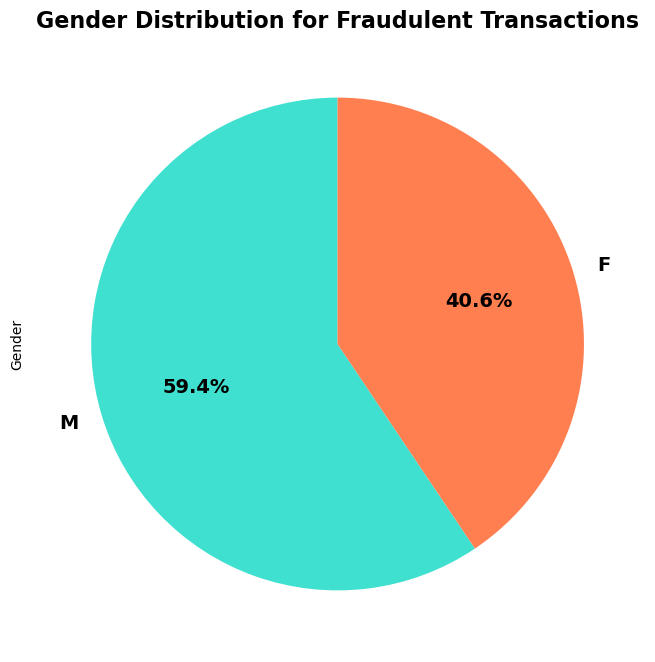

In [19]:
# Filter data for fraud transactions
fraud_data = data_df[data_df['Fraud'] == 1]
# Pie chart for Gender distribution with only fraud transactions
gender_fraud_counts = fraud_data['Gender'].value_counts()

# Increase font size for percentage and make it bold
plt.figure(figsize=(8, 8))
gender_fraud_counts.plot.pie(autopct='%1.1f%%', startangle=90, colors=['turquoise', 'coral'], textprops={'fontsize': 14, 'fontweight': 'bold'})
plt.title('Gender Distribution for Fraudulent Transactions', fontsize=16, fontweight='bold')
plt.show() 

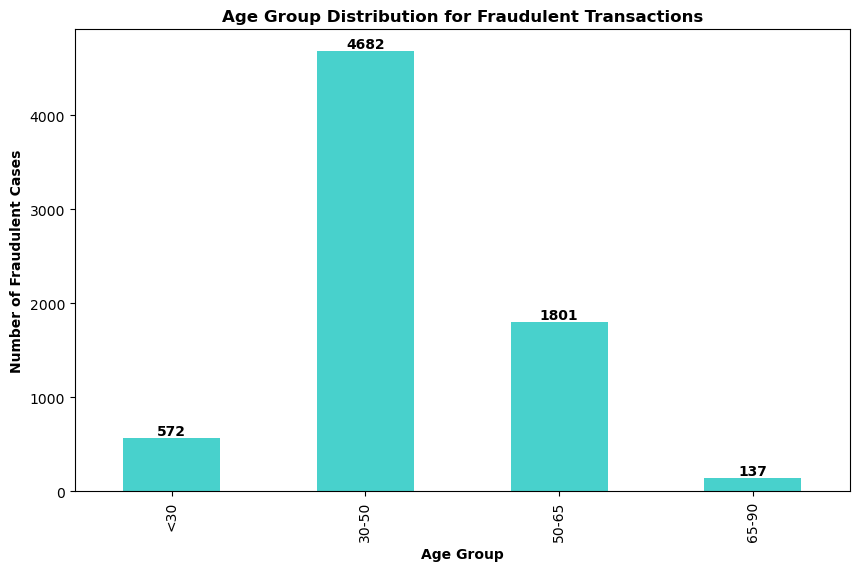

In [20]:
data_df['AgeGroup'] = pd.cut(data_df['Age'], bins=[15, 30, 50, 65, 90], labels=["<30", "30-50", "50-65", "65-90"])

fraud_data = data_df[data_df['Fraud'] == 1]
age_group_fraud_counts = fraud_data['AgeGroup'].value_counts()

# Sorting the index to ensure the bar chart is in ascending order
age_group_fraud_counts = age_group_fraud_counts.sort_index()

plt.figure(figsize=(10, 6))
ax = age_group_fraud_counts.plot(kind='bar', color='mediumturquoise')

# Making the title and axis labels bold
plt.title('Age Group Distribution for Fraudulent Transactions', fontweight='bold')
plt.xlabel('Age Group', fontweight='bold')
plt.ylabel('Number of Fraudulent Cases', fontweight='bold')

# Adding count labels below the bars and making them bold
for i, v in enumerate(age_group_fraud_counts):
    ax.text(i, v + 0.1, str(v), ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.show()

# At what times of the day is credit card fraud most frequently observed?
---
Assumption: all the Time mentioned here is from BST timezone (The United Kingdom)

### Conclusions:
 - There are two peeks of fraud during the day:
     - 0 AM - 6 AM 
     - 1 PM
  - percentage of the amount of fraud transactions out of the total transaction amount for a specific time of the day is lower than the percentage of the fraud transaction count out of the total transaction count for the same time of the day, which could mean that on average fraud transactions are of a lower value than other transactions
  - Fraud Count correlate with Fraud Amount, which mean that on average the values of fraud transaction for a (Day X Time) is more or less consistent, which could mean in its turn that there might be some specific segment of profiles affected the most. The slope here is 0.5, which can help us to predict the increase of one parameter using the other, e.g. 1% increase in the fraud transactions count would give increase in fraud amount 0.5%. Also we can use this info to concentrate on either of the above metric rather then on both of them



In [21]:
f_path = Path("Resources/cleaned_data.csv")
cleaned_data = pd.read_csv(f_path, index_col=0)

# leave only Tuesday and Wednesday
cleaned_data=cleaned_data[(cleaned_data["Day of Week"]=="Tuesday")|(cleaned_data["Day of Week"]=="Wednesday")]
# and have one df for a fraud data only
data_fraud=cleaned_data[cleaned_data["Fraud"]==1].copy().reset_index(drop=True)
data_fraud


,Date,Day of Week,Time,Type of Card,Entry Mode,Amount (in £),Type of Transaction,Merchant Group,Country of Transaction,Shipping Address,Country of Residence,Gender,Age,Bank,Fraud
0,2020-10-13,Tuesday,23,Visa,CVC,91.0,Online,Electronics,USA,USA,United Kingdom,M,38,Halifax,1
1,2020-10-14,Wednesday,1,MasterCard,PIN,106.0,POS,Fashion,Russia,Russia,United Kingdom,F,48,Metro,1
2,2020-10-13,Tuesday,0,MasterCard,CVC,25.0,Online,Food,Russia,Russia,United Kingdom,M,54,Barclays,1
3,2020-10-14,Wednesday,3,MasterCard,PIN,5.0,ATM,Services,China,China,United Kingdom,F,62,Barclays,1
4,2020-10-14,Wednesday,4,Visa,PIN,206.0,POS,Children,United Kingdom,India,United Kingdom,M,46,Barclays,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7184,2020-10-14,Wednesday,1,MasterCard,PIN,30.0,ATM,Fashion,China,China,United Kingdom,M,33,Barclays,1
7185,2020-10-13,Tuesday,12,MasterCard,CVC,386.0,Online,Products,China,China,United Kingdom,M,56,Barclays,1
7186,2020-10-13,Tuesday,18,Visa,PIN,21.0,ATM,Subscription,United Kingdom,USA,United Kingdom,M,50,Barclays,1
7187,2020-10-13,Tuesday,9,MasterCard,CVC,211.0,Online,Subscription,China,China,United Kingdom,F,44,Barclays,1


<Axes: >

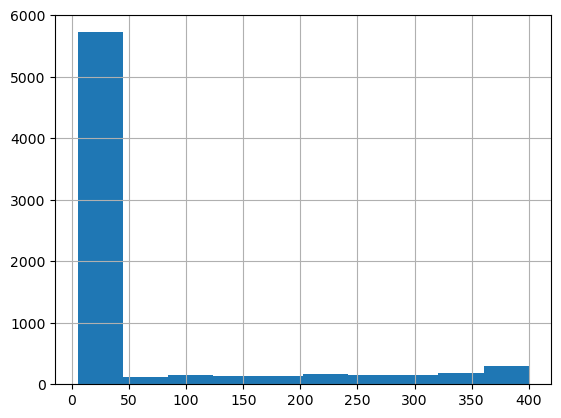

In [22]:
data_fraud["Amount (in £)"].hist()

<Axes: >

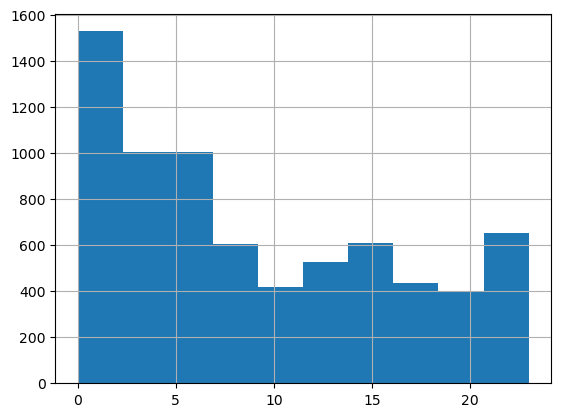

In [23]:
data_fraud["Time"].hist()

In [24]:
#while analyzing amount, we will take mode per (time X day), as far as data are obviously skewed
# source for mode calculation: https://stackoverflow.com/questions/50208007/calculate-mode-of-a-column-in-pandas-using-other-column-with-same-row-values 
fraud_mode=data_fraud.groupby(["Day of Week", "Time"]).agg({"Amount (in £)": lambda x: x.value_counts().index[0]}).reset_index()   
fraud_mode=fraud_mode.rename(columns={"Amount (in £)":"Amount Mode"})
# count transactions per (time X Day), etc.
fraud_count=pd.DataFrame(data_fraud.groupby(["Day of Week", "Time"]).size()).rename(columns={0:"Count"}).reset_index()
fraud_over_time=pd.merge(fraud_mode,fraud_count, on=["Day of Week","Time"], how="outer")

fraud_max=pd.DataFrame(data_fraud.groupby(["Day of Week", "Time"])["Amount (in £)"].max()).rename(columns={"Amount (in £)":"Amount Max"}).reset_index()
fraud_avg=pd.DataFrame(data_fraud.groupby(["Day of Week", "Time"])["Amount (in £)"].mean()).rename(columns={"Amount (in £)":"Amount Avg"}).reset_index()
fraud_over_time=pd.merge(fraud_over_time, fraud_max, on=["Day of Week","Time"], how="outer")
fraud_over_time=pd.merge(fraud_over_time, fraud_avg, on=["Day of Week","Time"], how="outer")

fraud_over_time.sort_values(by="Time")

,Day of Week,Time,Amount Mode,Count,Amount Max,Amount Avg
0,Tuesday,0,16.0,262,397.0,67.442748
24,Wednesday,0,15.0,248,400.0,68.604839
25,Wednesday,1,28.0,227,389.0,57.290749
1,Tuesday,1,6.0,256,400.0,68.144531
2,Tuesday,2,15.0,283,400.0,52.494700
26,Wednesday,2,7.0,253,380.0,58.256917
3,Tuesday,3,16.0,272,398.0,59.569853
27,Wednesday,3,24.0,259,400.0,81.861004
4,Tuesday,4,24.0,245,399.0,61.016327
28,Wednesday,4,24.0,229,400.0,73.366812


<Figure size 800x500 with 0 Axes>

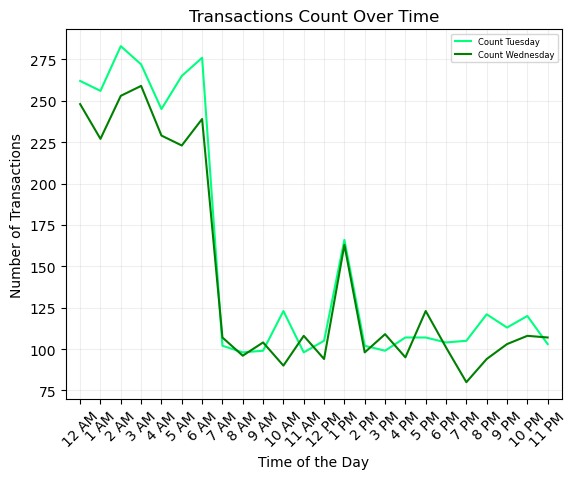

In [25]:
plt.figure(figsize=(8, 5))
fig, ax = plt.subplots()
#plotting two lines for two subsets: Tuesday and Wednesday
subset=fraud_over_time[fraud_over_time["Day of Week"]=="Tuesday"]
ax.plot(subset["Time"], subset["Count"], color="springgreen",label="Count Tuesday")

subsetW=fraud_over_time[fraud_over_time["Day of Week"]=="Wednesday"]
ax.plot(subsetW["Time"], subsetW["Count"], color="green",label="Count Wednesday")
tick_loc=subsetW["Time"].unique()
# setting labels for x-axis
labels_t=["12 AM"]
for i in range(1,12): 
    labels_t.append(f"{i} AM")
labels_t.append("12 PM")
for i in range(1,12): 
    labels_t.append(f"{i} PM")
ax.set_xticks(range(0,24))
ax.set_xticklabels(labels_t, rotation=45)

ax.set_ylabel("Number of Transactions")
ax.set_xlabel("Time of the Day")
ax.set_title("Transactions Count Over Time")
ax.legend( loc="best",prop={'size': 6})
ax.grid(alpha=0.2)
ax.set_xlim(-0.7,23.7)
plt.show()

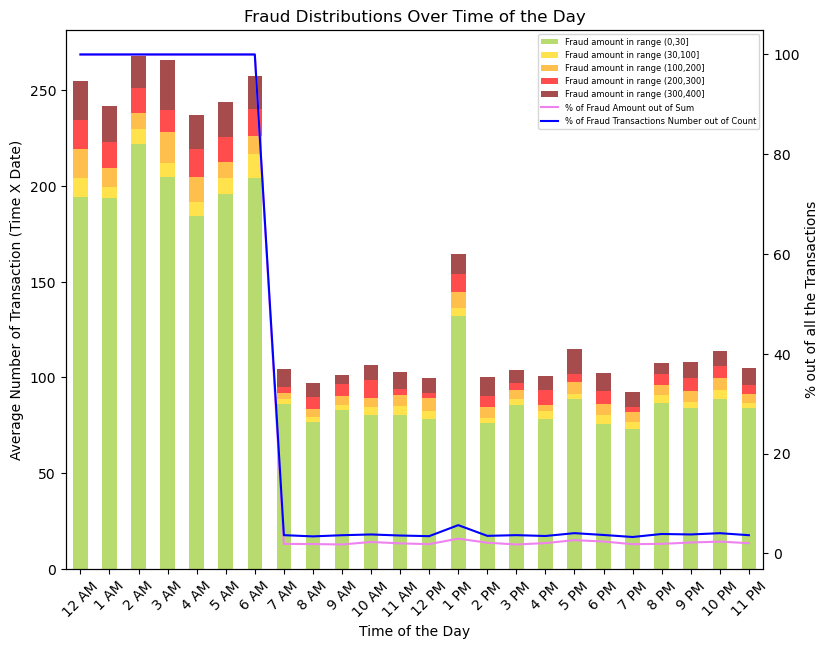

In [26]:
# assuming that we could have lots of days let us look at more generic picture, using averages
# and compare data for amount vs count over time
# split amount into few size bins
size_bins = [0, 30, 100, 200, 300, 400]
labels = ["Fraud amount in range (0,30]", "Fraud amount in range (30,100]", "Fraud amount in range (100,200]", "Fraud amount in range (200,300]", "Fraud amount in range (300,400]"]
colors=["yellowgreen", "gold", "orange", "red", "maroon"]  #https://matplotlib.org/stable/gallery/color/named_colors.html
cleaned_data["Fraud Size"] = pd.cut(cleaned_data["Amount (in £)"], bins=size_bins, labels=labels)

data_stecked=cleaned_data.loc[cleaned_data["Fraud"]==1,["Time", "Fraud Size"]].copy()
data_stecked=data_stecked.groupby(["Time", "Fraud Size"]).size()
data_stecked=pd.DataFrame(data_stecked).rename(columns={0:"Size Count"}).reset_index()


#find averages
day_count=cleaned_data["Date"].nunique()

for i, row in data_stecked.iterrows():
    data_stecked.loc[i,"Size Count"]=row["Size Count"]/day_count

# switch Fraud Size column to a row; source: https://www.w3resource.com/pandas/dataframe/dataframe-pivot.php
data_stecked = data_stecked.pivot(index='Time', columns='Fraud Size', values='Size Count').fillna(0)

# create shared figuer and x axis
fig, ax = plt.subplots(figsize=(6,5))

# Create the stacked bar chart; source: https://www.geeksforgeeks.org/create-a-stacked-bar-plot-in-matplotlib/
data_stecked.plot(kind='bar', stacked=True, ax=ax, color=colors, figsize=(9, 7), alpha=0.7, legend=False)

#function for calculating the rate
def perc(df, col1, col2, res_col1, res_col2):
    df[res_col1]=""
    df[res_col2]=""
    for i, row in df.iterrows():
        sum_c=row[col1]+row[col2]
        df.loc[i,res_col1]=100*row[col1]/sum_c
        df.loc[i,res_col2]=100*row[col2]/sum_c
    return df

area_df1=cleaned_data.groupby(["Time","Fraud"]).size()
area_df1=pd.DataFrame(area_df1).reset_index().rename(columns={0:"Transaction Count"}).set_index("Time")
area_df1=area_df1.pivot(columns='Fraud', values='Transaction Count').fillna(0)
area_df1=perc(area_df1, 0,1,"Genuine Count %","Fraud Count %")

area_df2=cleaned_data.groupby(["Time","Fraud"])["Amount (in £)"].sum()
area_df2=pd.DataFrame(area_df2).reset_index().rename(columns={"Amount (in £)":"Transaction Amount"}).set_index("Time")
area_df2=area_df2.pivot(columns='Fraud', values='Transaction Amount').fillna(0)
area_df2=perc(area_df2, 0,1,"Genuine Amount %","Fraud Amount %")

ax2=ax.twinx() # magic for having two x axis; source: https://samchaaa.medium.com/how-to-plot-two-different-scales-on-one-plot-in-matplotlib-with-legend-46554ba5915a
l1=area_df2.plot(y=["Fraud Amount %"], ax=ax2, color="violet", legend=False)
area_df1.plot(y=["Fraud Count %"], ax=ax2, color="blue", legend=False) 
# setting label per each line; source: https://stackoverflow.com/questions/64111555/get-lines-and-labels-from-matplotlib-axes
l1.get_lines()[0].set_label("% of Fraud Amount out of Sum")
l1.get_lines()[1].set_label("% of Fraud Transactions Number out of Count")


ax.set_ylabel("Average Number of Transaction (Time X Date)")
ax2.set_ylabel("% out of all the Transactions")
ax.set_xlabel("Time of the Day")
ax.set_xticks(range(0,24))
ax.set_xticklabels(labels_t, rotation=45)
ax.set_title("Fraud Distributions Over Time of the Day")

# add legend for all charts https://stackoverflow.com/questions/5484922/secondary-axis-with-twinx-how-to-add-to-legend
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc="best",prop={'size': 6})


The r-value is:0.8079918305382258


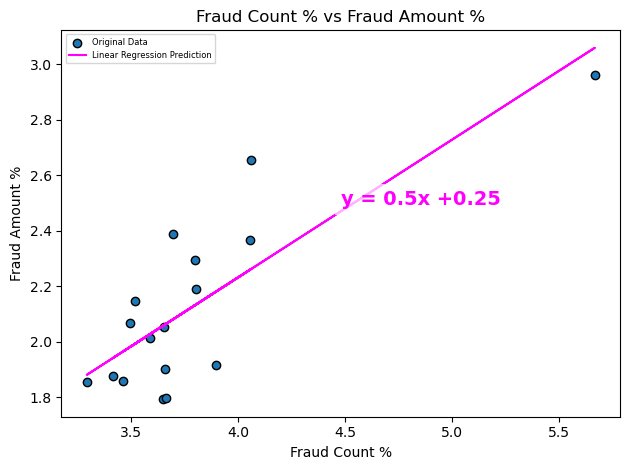

In [27]:
# count and amount seem to go together, so let us look at correlation
df_merged_perc=pd.merge(area_df1[["Genuine Count %","Fraud Count %"]],area_df2[["Genuine Amount %","Fraud Amount %"]], left_index=True, right_index=True)
df_merged_perc.reset_index()
df_merged_perc["Fraud Count %"]=df_merged_perc["Fraud Count %"].astype("float")
df_merged_perc["Fraud Amount %"]=df_merged_perc["Fraud Amount %"].astype("float")
df_merged_perc=df_merged_perc[~(df_merged_perc["Fraud Count %"]==100)]
df_merged_perc
# Define a function to create Linear Regression plots
def lin_reg(x, y, x_label, y_label):
    slope, b, lin_corr, _, _ = st.linregress(x,y)
    pred=slope*x+b
    
    #print r-value
    print(f"The r-value is:{lin_corr}")

    # Create line equation string
    if abs(round(slope,2))>0: eq=f"y = {round(slope,2)}x +{round(b,2)}"
    else: #we want to omit y=0.0x+b situation
        non_zero_decimal_position=2
        decimals=str(slope).split(".")[1] #https://www.softwaretestinghelp.com/python/python-string-split/
        i=decimals[2] #https://buzzcoder.gitbooks.io/codecraft-python/content/string/loop-through-a-string.html
        while i=='0': 
            non_zero_decimal_position+=1
            i=decimals[non_zero_decimal_position]
        eq=f"y = {round(slope,non_zero_decimal_position+1)}x +{round(b,2)}"
        
    #plot the above regression line along with x_column_name vs y_column_name dependency
    fig, ax = plt.subplots(1,1)
    #plot
    ax.scatter(x=x,y=y, marker="o", edgecolor="black", label="Original Data")
    ax.plot(x,pred, color="fuchsia", label="Linear Regression Prediction")
    #annotation
    x_p=x.max()-(x.max()-x.min())/2
    y_p=slope*x_p+b+(y.max()-y.min())/50
    ax.annotate(eq,(x_p,y_p),fontsize=14, fontweight="bold", color="fuchsia", bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))
    #labels...
    ax.set_xlabel(x_label)
    ax.set_ylabel(f"{y_label}")
    ax.set_title(f"{x_label} vs {y_label}")  
    ax.legend(loc="best",prop={'size': 6})
    plt.tight_layout()
    # Show plot
    plt.show()
    
    
lin_reg(df_merged_perc["Fraud Count %"],df_merged_perc["Fraud Amount %"],"Fraud Count %", "Fraud Amount %")


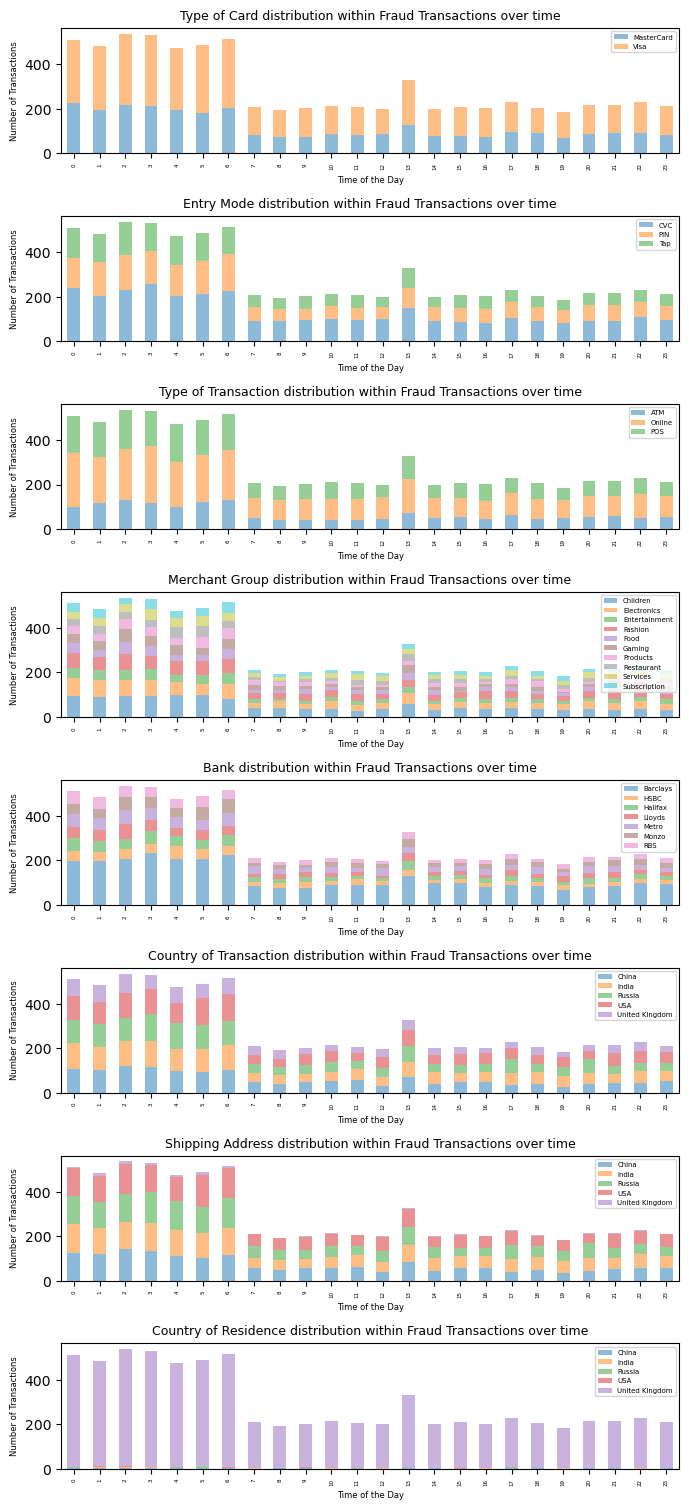

In [28]:
# let us very briefly check distributions of different paramenters over the day

#create a function for building of bar charts
def stacked_bars(df, x_column, y_column, y_values, ax):
    df_stecked=df.loc[:,[x_column, y_column]].copy()
    df_stecked=df_stecked.groupby([x_column, y_column]).size()
    df_stecked=pd.DataFrame(df_stecked).rename(columns={0:y_values}).reset_index()
  # switch Fraud Size column to a row
    df_stecked = df_stecked.pivot(index=x_column, columns=y_column, values=y_values).fillna(0)
  # Create the stacked bar chart
    df_stecked.plot(kind='bar', stacked=True, ax=ax, alpha=0.5)
    ax.tick_params(axis='x', labelsize=4)
    ax.set_title(f"{y_column} distribution within Fraud Transactions over time", size=9)
    ax.set_ylabel("Number of Transactions", size=6)
    ax.set_xlabel("Time of the Day", size=6)
    ax.legend(loc="best",prop={'size': 5})

#working with only fraud data, so will use data_fraud
fig, ax = plt.subplots(8, 1, figsize=(7, 15))
fig.tight_layout()
fig.subplots_adjust(hspace=0.5)

# building stacked bars:
stacked_bars(data_fraud, "Time", "Type of Card", "Count of Transactions", ax[0])
stacked_bars(data_fraud, "Time", "Entry Mode", "Count of Transactions",  ax[1])
stacked_bars(data_fraud, "Time", "Type of Transaction", "Count of Transactions",  ax[2])
stacked_bars(data_fraud, "Time", "Merchant Group", "Count of Transactions",  ax[3])
stacked_bars(data_fraud, "Time", "Bank", "Count of Transactions",  ax[4])
stacked_bars(data_fraud, "Time", "Country of Transaction", "Count of Transactions",  ax[5])
stacked_bars(data_fraud, "Time", "Shipping Address", "Count of Transactions",  ax[6])
stacked_bars(data_fraud, "Time", "Country of Residence", "Count of Transactions",  ax[7])


In [29]:
# let us quickly look at correlations for numerical fields within fraud transactions vs for the whole set of data
data_fraud.dtypes

Date                       object
Day of Week                object
Time                        int64
Type of Card               object
Entry Mode                 object
Amount (in £)             float64
Type of Transaction        object
Merchant Group             object
Country of Transaction     object
Shipping Address           object
Country of Residence       object
Gender                     object
Age                         int64
Bank                       object
Fraud                       int64
dtype: object

In [30]:
data_fraud[["Time","Amount (in £)","Age"]].corr()

,Time,Amount (in £),Age
Time,1.000000,0.005955,-0.008375
Amount (in £),0.005955,1.000000,-0.004843
Age,-0.008375,-0.004843,1.000000


In [31]:
cleaned_data[["Time","Amount (in £)","Age", "Fraud"]].corr()

,Time,Amount (in £),Age,Fraud
Time,1.000000,0.029976,-0.001102,-0.286473
Amount (in £),0.029976,1.000000,-0.004291,-0.109896
Age,-0.001102,-0.004291,1.000000,-0.002848
Fraud,-0.286473,-0.109896,-0.002848,1.000000


# Project 1 
## Which countries are most frequently associated with Fraud Credit Card transactions within our dataset?

Our assumed client from UK asked to investigate 2 days transaction data (close to 10 000 transactions) gathered from 7 institutions to find out which countries are most frequently associated with Fraud transactions and if there are any patterns within Fraud transactions related to country information.

#### Conclusions:
 - About 98% of Fraud transactions associated with UK recidence, however, around 83% of all Fraud transactions have different Country, mentioned within Transaction and Shipping Addresses (with actually same Transaction and Shipping). Almost all the rest fraud transactions (around 16%) have same Recidence and Transaction, but different Shipping address. This pattern is not applicable to genuine transactions with 83% of transactions with same Shipping, Recidence and Transaction adresses.
 - Having the above in mind we can assume that for fraud transactions country of shipping can be treated as a fraud initiator. This results in final conclusion that there is 1.7% of fraud associated with UK and the rest is split into 4 countries almost equally (24-25%).



In [32]:
#!pip install matplotlib-venn

In [33]:
#concentrate on transactions count analysis per country so far
data_country=cleaned_data[["Country of Transaction", "Shipping Address", "Country of Residence", "Fraud", "Amount (in £)"]].copy().reset_index(drop=True)
data_country_fraud=data_country[data_country["Fraud"]==1].copy()
data_country_fraud

,Country of Transaction,Shipping Address,Country of Residence,Fraud,Amount (in £)
4,USA,USA,United Kingdom,1,91.0
11,Russia,Russia,United Kingdom,1,106.0
16,Russia,Russia,United Kingdom,1,25.0
37,China,China,United Kingdom,1,5.0
42,United Kingdom,India,United Kingdom,1,206.0
...,...,...,...,...,...
99900,China,China,United Kingdom,1,30.0
99905,China,China,United Kingdom,1,386.0
99920,United Kingdom,USA,United Kingdom,1,21.0
99925,China,China,United Kingdom,1,211.0


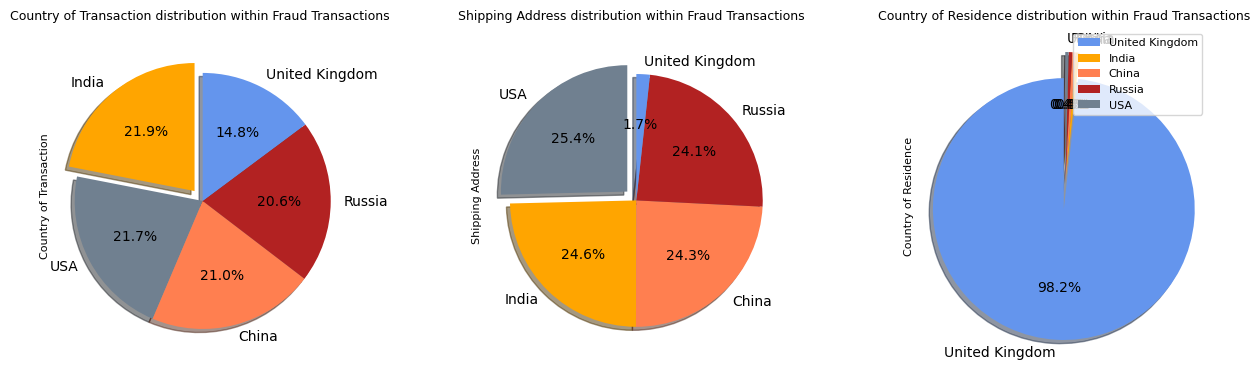

In [34]:
# #create a function for building of pie charts
def pies (groupped_y, ax, color_mapping, legend, explode, start_angle):
    y_name=groupped_y.name
    colors = [color_mapping[country] for country in groupped_y.index]
    groupped_y.plot(kind="pie",autopct="%1.1f%%",labels=groupped_y.index, 
                    ylabel=y_name, ax=ax, colors=colors, legend=legend,
                    shadow=True, explode=explode, startangle=start_angle)
    ax.set_title(f"{y_name} distribution within Fraud Transactions", size=9)
    ax.set_ylabel(y_name, size=8)
    ax.axis("equal")
    
# preparing subplots object
fig, ax = plt.subplots(1, 3)

# share same color per Country per diff charts; source: https://github.com/geopandas/geopandas/issues/1269
color_mapping = {"USA": "slategrey", "China": "coral", "India": "orange", "Russia": "firebrick", "United Kingdom": "cornflowerblue"}

# building pie charts:
temp=data_country_fraud["Country of Transaction"].value_counts()
pies(temp, ax[0], color_mapping, False, (0.1,0,0,0,0), 90)
temp=data_country_fraud["Shipping Address"].value_counts()                        
pies(temp, ax[1], color_mapping, False, (0.1,0,0,0,0), 90)
temp=data_country_fraud["Country of Residence"].value_counts()                         
pies(temp, ax[2], color_mapping, False, (0.2,0,0,0,0), 90)
plt.legend(loc="upper right",prop={'size': 8})
# adjust spasing between subplots; source:  https://www.geeksforgeeks.org/how-to-set-the-spacing-between-subplots-in-matplotlib-in-python/
plt.subplots_adjust(left=0.7,
                    bottom=0.3,
                    right=2.5,
                    top=1,
                    wspace=0.5,
                    hspace=0.5)

plt.show()

In [35]:
# let us group data to check if there is something interesting regarding address
combinations_counts=data_country_fraud.groupby(["Country of Transaction", "Shipping Address", "Country of Residence"]).size()
combinations_counts=pd.DataFrame(combinations_counts).reset_index()
combinations_counts=combinations_counts.rename(columns={0:"Fraud Transactions Count"})
combinations_counts 

,Country of Transaction,Shipping Address,Country of Residence,Fraud Transactions Count
0,China,China,China,1
1,China,China,United Kingdom,1478
2,China,United Kingdom,China,31
3,India,India,India,2
4,India,India,United Kingdom,1544
5,India,United Kingdom,India,31
6,Russia,Russia,Russia,1
7,Russia,Russia,United Kingdom,1448
8,Russia,United Kingdom,Russia,30
9,USA,USA,United Kingdom,1528


In [36]:
# there is obviously a pattern in the above when try separately, 
    # so let us visualize it with venn diagram

In [37]:
def venn_d(df, set1_column_name, set2_column_name, set3_column_name, colors, type_t):
    combinations_counts=df.groupby([set1_column_name, set2_column_name, set3_column_name]).size()
    combinations_counts=pd.DataFrame(combinations_counts).reset_index()
    count_column_name=f"{type_t} Transactions Count"
    combinations_counts=combinations_counts.rename(columns={0:count_column_name})
    # let us prepare numbers of overlapped vs not overlapped data for venn diagram 

    combinations_counts["Transaction=Shipping"]=[0 for i in combinations_counts.index]
    combinations_counts["Shipping=Residence"]=[0 for i in combinations_counts.index]
    combinations_counts["Transaction=Residence"]=[0 for i in combinations_counts.index]
    combinations_counts["Transaction=Shipping=Residence"]=[0 for i in combinations_counts.index]
    combinations_counts["No overlap"]=[0 for i in combinations_counts.index]


    for i, row in combinations_counts.iterrows():
        if ((row["Country of Transaction"] == row["Country of Residence"])&(row["Country of Transaction"] == row["Shipping Address"])):combinations_counts.loc[i,"Transaction=Shipping=Residence"]+=row[count_column_name]
        elif row["Country of Transaction"]== row["Shipping Address"]: combinations_counts.loc[i,"Transaction=Shipping"]+=row[count_column_name]
        elif row["Country of Transaction"]== row["Country of Residence"]: combinations_counts.loc[i,"Transaction=Residence"]+=row[count_column_name]
        elif row["Shipping Address"]== row["Country of Residence"]:combinations_counts.loc[i,"Shipping=Residence"]+=row[count_column_name]
        else:   combinations_counts.loc[i,"No overlap"]+=row[count_column_name]
    combinations_counts  

    # few more preparation of data for venn diagram; 
    # sources for how to build venn: 
    # - https://www.geeksforgeeks.org/how-to-create-and-customize-venn-diagrams-in-python/
    # - https://stackoverflow.com/questions/19841535/python-matplotlib-venn-diagram
    totals=combinations_counts[count_column_name].sum()
    only=round(100*(combinations_counts["No overlap"].sum())/totals,1)
    RS=round(100*(combinations_counts["Shipping=Residence"].sum())/totals,1)
    RT=round(100*(combinations_counts["Transaction=Residence"].sum())/totals,1)
    ST=round(100*(combinations_counts["Transaction=Shipping"].sum())/totals,1)
    RST=round(100*(combinations_counts["Transaction=Shipping=Residence"].sum())/totals,1)

    # order: Only r, Only s, r ∩ s, Only t, r ∩ t, s ∩ t, r ∩ s ∩ t
    v = venn3(subsets=(only,only,RS,only,RT,ST,RST),set_labels=('Residence','Shipping','Transaction'), set_colors=(colors[0], colors[1], colors[2]))
    v.get_label_by_id('A').set_color(colors[0])
    v.get_label_by_id('B').set_color(colors[1])
    v.get_label_by_id('C').set_color(colors[2])
    plt.title(f"Overlap of Countries in {type_t} Transactions: Residence, Shipping, Transaction (%)", size=9)

    plt.show()
    return combinations_counts

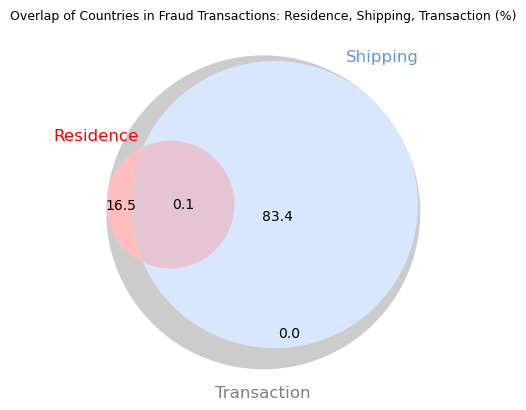

,Country of Transaction,Shipping Address,Country of Residence,Fraud Transactions Count,Transaction=Shipping,Shipping=Residence,Transaction=Residence,Transaction=Shipping=Residence,No overlap
0,China,China,China,1,0,0,0,1,0
1,China,China,United Kingdom,1478,1478,0,0,0,0
2,China,United Kingdom,China,31,0,0,31,0,0
3,India,India,India,2,0,0,0,2,0
4,India,India,United Kingdom,1544,1544,0,0,0,0
5,India,United Kingdom,India,31,0,0,31,0,0
6,Russia,Russia,Russia,1,0,0,0,1,0
7,Russia,Russia,United Kingdom,1448,1448,0,0,0,0
8,Russia,United Kingdom,Russia,30,0,0,30,0,0
9,USA,USA,United Kingdom,1528,1528,0,0,0,0


In [38]:
colors=("red", "cornflowerblue", "grey")
venn_d(data_country_fraud, "Country of Transaction", "Shipping Address", "Country of Residence", colors, "Fraud")

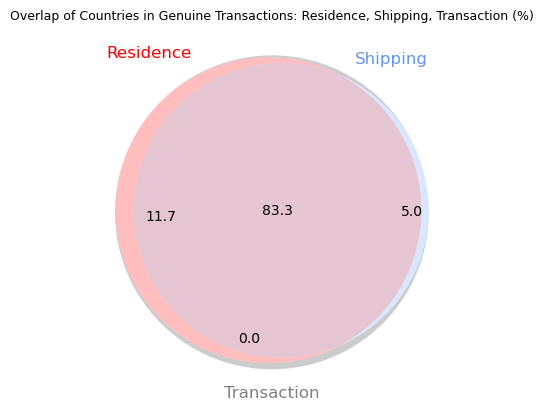

,Country of Transaction,Shipping Address,Country of Residence,Genuine Transactions Count,Transaction=Shipping,Shipping=Residence,Transaction=Residence,Transaction=Shipping=Residence,No overlap
0,China,China,China,4322,0,0,0,4322,0
1,China,China,United Kingdom,1144,1144,0,0,0,0
2,China,United Kingdom,China,174,0,0,174,0,0
3,India,India,India,4183,0,0,0,4183,0
4,India,India,United Kingdom,1146,1146,0,0,0,0
5,India,United Kingdom,India,186,0,0,186,0,0
6,Russia,Russia,Russia,4370,0,0,0,4370,0
7,Russia,Russia,United Kingdom,1189,1189,0,0,0,0
8,Russia,United Kingdom,Russia,213,0,0,213,0,0
9,USA,USA,USA,4371,0,0,0,4371,0


In [39]:
#let us check same for genuine transactions
data_country=cleaned_data[["Country of Transaction", "Shipping Address", "Country of Residence", "Fraud", "Amount (in £)"]].copy().reset_index(drop=True)
data_country_gen=data_country[data_country["Fraud"]==0].copy()
venn_d(data_country_gen, "Country of Transaction", "Shipping Address", "Country of Residence", colors, "Genuine")

In [40]:
# interesting to investigate shipped address a little more
# for this purpose build a distribution of a transactions countries records by shipped countries records
stacked_df=combinations_counts.groupby(["Country of Transaction","Shipping Address"])["Fraud Transactions Count"].sum()
stacked_df=stacked_df.reset_index()
stacked_df=stacked_df.pivot(index="Country of Transaction", columns="Shipping Address", values="Fraud Transactions Count").fillna(0)
stacked_df

Shipping Address,China,India,Russia,USA,United Kingdom
Country of Transaction,,,,,
China,1479.0,0.0,0.0,0.0,31.0
India,0.0,1546.0,0.0,0.0,31.0
Russia,0.0,0.0,1449.0,0.0,30.0
USA,0.0,0.0,0.0,1528.0,30.0
United Kingdom,265.0,220.0,281.0,297.0,2.0


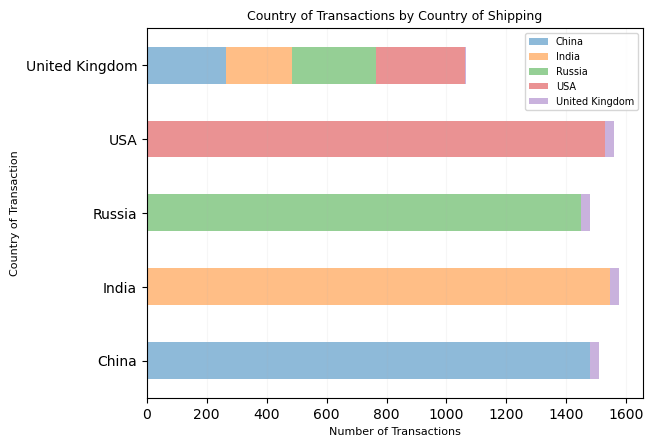

In [41]:
ax = plt.subplot()
stacked_df.plot(kind='barh', stacked=True, ax=ax, alpha=0.5)
ax.set_title("Country of Transactions by Country of Shipping", size=9)
ax.set_ylabel("Country of Transaction", size=8)
ax.set_xlabel("Number of Transactions", size=8)
ax.legend(loc="best",prop={'size': 7})
plt.grid(axis='x', alpha=0.1)

In [42]:
# identify % of transactions for each country taking into account shipping address specific
#prep list of countries
countries=stacked_df.columns
countries.name="Country"
countries

Index(['China', 'India', 'Russia', 'USA', 'United Kingdom'], dtype='object', name='Country')

In [43]:
#let us calculate percentage of transactions per Country
def country_perc(df,type_t,countries,step_x):
    temp_df=pd.DataFrame(countries).set_index("Country")
    count_column_name=f"{type_t} Transactions Count"
    temp_df[count_column_name]=""
    for i in df.columns:
        temp_df.loc[i,count_column_name]=df[i].sum()
    total_F= temp_df[count_column_name].sum()   
    map_df_p=temp_df.copy()
    perc_column_name=f"{type_t} Transactions (%)"
    map_df_p[perc_column_name]=[round(100*i/total_F,1) for i in map_df_p[count_column_name]]
    map_df_p=map_df_p.drop(count_column_name, axis=1)

    #visualize the above %
    max_y=int(map_df_p[perc_column_name].max())+1
    labels_t=[]
    for i in range(0,max_y,step_x): 
        labels_t.append(f"{i} %")
    ax = map_df_p.plot(kind='barh')
    ax.set_xticks(range(0,max_y,step_x))

    ax.set_xticklabels(labels_t, ha='center', va='top', rotation=45, size=7) 
    ax.set_xlim(-0.25, max_y+0.1)
    plt.title(f"Contries, associated as {type_t} initiator (%)")
    plt.legend(loc="best", prop={'size': 6})
    plt.grid(axis='x', alpha=0.1)
    plt.figure(figsize=(5, 25))
    plt.tight_layout()
    plt.show()
    
    return map_df_p

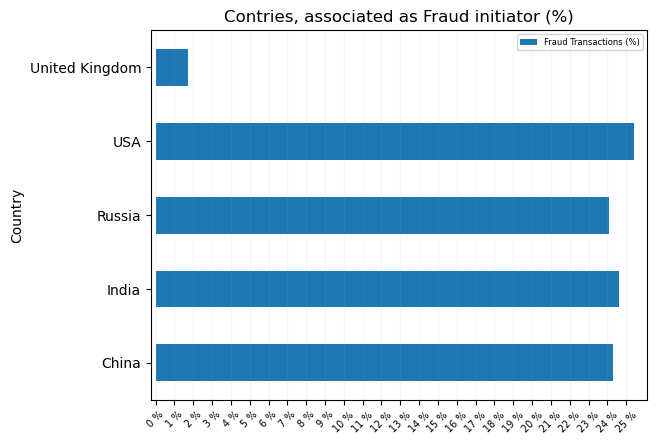

<Figure size 500x2500 with 0 Axes>

In [44]:
#calculate the Country share within Fraud data
fraud_perc=country_perc(stacked_df,"Fraud",countries,1)

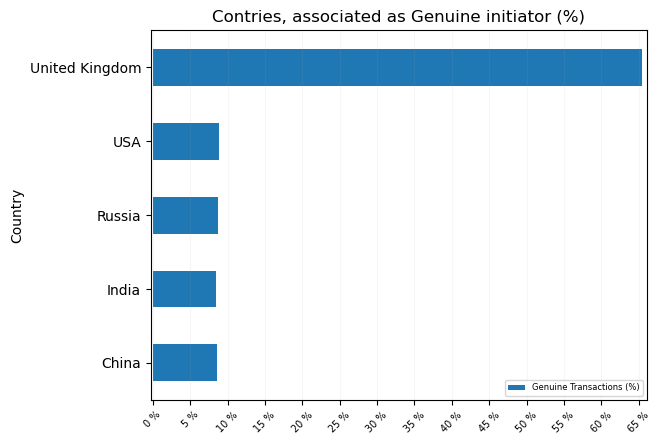

<Figure size 500x2500 with 0 Axes>

In [45]:
# do the same for genuine set
data_country=cleaned_data[["Country of Transaction", "Shipping Address", "Country of Residence", "Fraud", "Amount (in £)"]].copy().reset_index(drop=True)
data_country_gen=data_country[data_country["Fraud"]==0].copy()
combinations_counts=data_country_gen.groupby(["Country of Transaction", "Shipping Address", "Country of Residence"]).size()
combinations_counts=pd.DataFrame(combinations_counts).reset_index()
combinations_counts=combinations_counts.rename(columns={0:"Genuine Transactions Count"})
ship_cleaned=combinations_counts.groupby(["Country of Transaction","Shipping Address"])["Genuine Transactions Count"].sum()
ship_cleaned=ship_cleaned.reset_index()
ship_cleaned=ship_cleaned.pivot(index="Country of Transaction", columns="Shipping Address", values="Genuine Transactions Count").fillna(0)

# ax.set_xlim(-0.25, max_y+0.25)
# ax.set_xlim(-0.25, max_y-0.5)

gen_perc=country_perc(ship_cleaned,"Genuine",countries,5)

In [46]:
# merge data for overall view
ship_merged=pd.merge(gen_perc, fraud_perc, on="Country")
ship_merged

,Genuine Transactions (%),Fraud Transactions (%)
Country,,
China,8.6,24.3
India,8.4,24.6
Russia,8.7,24.1
USA,8.9,25.4
United Kingdom,65.5,1.7


In [47]:
# prep data for a line with % of Fraud by Country within the whole set of transactions
df_prop=cleaned_data[["Shipping Address","Fraud"]]
distribution_c=df_prop.groupby(["Shipping Address","Fraud"]).size()
distribution_c=pd.DataFrame(distribution_c).reset_index().rename(columns={0:"transactions_count"})
distribution_c = distribution_c.pivot(index="Shipping Address", columns="Fraud", values="transactions_count").fillna(0)
distribution_c

Fraud,0,1
Shipping Address,,
China,7951,1744
India,7780,1766
Russia,8063,1730
USA,8211,1825
United Kingdom,60757,124


In [48]:
proportion=pd.DataFrame(countries).set_index("Country")
proportion["%Fraud"]=""
for i,row in distribution_c.iterrows():
    proportion.loc[i,"%Fraud"]=round(100*row[1]/(row[0]+row[1]),2)
proportion

,%Fraud
Country,
China,17.99
India,18.5
Russia,17.67
USA,18.18
United Kingdom,0.2


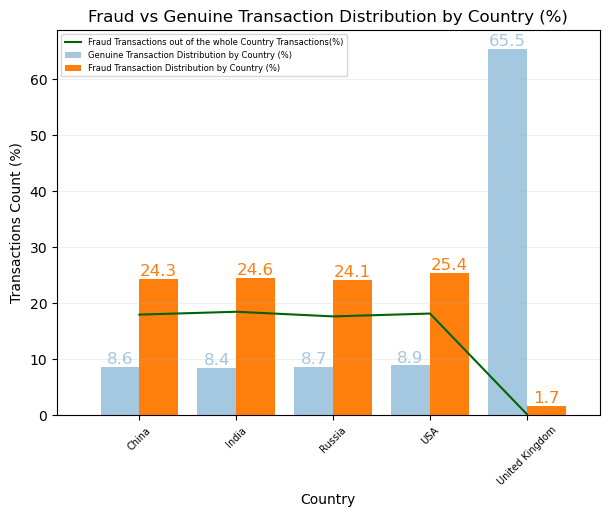

<Figure size 500x2500 with 0 Axes>

In [49]:
# and plot alltogether
# groupped bar charts; source: https://www.pythoncharts.com/matplotlib/grouped-bar-charts-matplotlib/
fig, ax = plt.subplots(figsize=(7,5))
bar_width = 0.4
length_x=len(ship_merged["Genuine Transactions (%)"])
x = np.arange(length_x)
ax.bar(x-bar_width/2,ship_merged["Genuine Transactions (%)"], alpha=0.4, width=bar_width, label="Genuine Transaction Distribution by Country (%)")
ax.bar(x+bar_width/2, ship_merged["Fraud Transactions (%)"], width=bar_width, label="Fraud Transaction Distribution by Country (%)") 
ax.set_xticks(x)
labls=ship_merged.index
ax.set_xticklabels(labls, ha='center', va='top', rotation=45, size=7)
ax.set_xlim(-0.85, length_x-0.25)
ax.grid(axis='y', alpha=0.2)

for bar in ax.patches: #source: https://www.pythoncharts.com/matplotlib/grouped-bar-charts-matplotlib/
  # The text annotation for each bar should be its height.
  bar_value = bar.get_height()
  # Format the text with commas to separate thousands. You can do
  # any type of formatting here though.
  text = f'{bar_value:,}'
  # This will give the middle of each bar on the x-axis.
  text_x = bar.get_x() + bar.get_width() / 2
  # get_y() is where the bar starts so we add the height to it.
  text_y = bar.get_y() + bar_value
  # If we want the text to be the same color as the bar, we can
  # get the color like so:
  bar_color = bar.get_facecolor()
  # If you want a consistent color, you can just set it as a constant, e.g. #222222
  ax.text(text_x, text_y, text, ha='center', va='bottom', color=bar_color,
          size=12)

#plot a line
ax.plot(proportion.index,proportion["%Fraud"], color="darkgreen", label="Fraud Transactions out of the whole Country Transactions(%)")
ax.set_ylabel("Transactions Count (%)")
ax.set_xlabel("Country")
    
plt.title("Fraud vs Genuine Transaction Distribution by Country (%)")
plt.legend(loc="best", prop={'size': 6})
plt.figure(figsize=(5, 25))
plt.tight_layout()
plt.show()

In [50]:
#map countries, based on transactions count

# identify number of transactions for each country taking into account shipping address specific
map_df=pd.DataFrame(countries).set_index("Country")
map_df["Fraud Transactions Count"]=""
for i in stacked_df.columns:
    map_df.loc[i,"Fraud Transactions Count"]=stacked_df[i].sum()
    
# check coordinates for countries
map_df["Lat"]=""
map_df["Lng"]=""
for i,row in map_df.iterrows():
    base_url="https://api.geoapify.com/v1/geocode/search"
    params={
        "text":i,
        "format":"json",
        "apiKey":geoapify_key
    }

    data=requests.get(base_url, params=params).json()

    # Extract lat/lon
    map_df.loc[i,"Lat"]=data['results'][0]['lat']
    map_df.loc[i,"Lng"]=data['results'][0]['lon']
map_df=map_df.reset_index()
map_df

,Country,Fraud Transactions Count,Lat,Lng
0,China,1744.0,35.000074,104.999927
1,India,1766.0,22.351115,78.667743
2,Russia,1730.0,64.686314,97.745306
3,USA,1825.0,39.78373,-100.445882
4,United Kingdom,124.0,54.702354,-3.276575


In [51]:
# be sure we have proper data type for map input
map_df["Fraud Transactions Count"]=map_df["Fraud Transactions Count"].astype("float64")

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
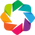

:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Points.I :Points   [Lng,Lat]   (Country,Fraud Transactions Count)

In [52]:
%%capture --no-display

# Configure the map plot
hv.extension('bokeh')
map_plot = map_df.hvplot.points(
    "Lng",
    "Lat",
    geo = True,
    tiles = "OSM",
    frame_width = 500,
    frame_height = 360,
    size = "Fraud Transactions Count",
    scale = 0.4,
    color="Country"
)

# Display the map
map_plot